# Vientos
El objetivo de este notebook es:
* Tratar los datos (ordenarlos, correlacionarlos entre otras cosas)
* Visualizar la data de la estación una estación de la región referido a la variable viento.
* Extraer estadísticos

Los datos son extraídos de la página de Sistema Nacional de Inforamción Hídrica SNHI (https://snih.hidricosargentina.gob.ar/Filtros.aspx#)

Leemos las librerías que necesitamos

In [1]:
# Recuerden siempre importar las librerías que vamos usar. Normalmente son estas 3
import pandas as pd #PANDAS
from matplotlib import pyplot as plt #Para plotear
import numpy as np  #Para operaciones matemáticas
from scipy.interpolate import interp1d #interpola los datos. Nos sirve para extraer información
import plotly.express as px

ModuleNotFoundError: No module named 'plotly'

Primero leemos la velocidad

In [2]:
#Lectura de datos
df = pd.read_excel('data/Historicos-Estacion 3005_velocidad.xlsx', 
                   skiprows=2, names =['datetime','velocidad'])

#pd.options.display.max_rows = 100
#skiprows salta las líneas necesarias que no queremos leer
df

datetime  velocidad
0      02/01/1993 22:00        3.2
1      03/01/1993 10:00        2.7
2      03/01/1993 16:00        2.1
3      03/01/1993 22:00        1.1
4      04/01/1993 10:00        1.2
...                 ...        ...
32705  29/06/2023 15:00        2.1
32706  29/06/2023 21:00        4.8
32707  30/06/2023 09:00        2.1
32708  30/06/2023 15:00        6.2
32709  30/06/2023 21:00        6.1

[32710 rows x 2 columns]

In [3]:
#Corrección de dato de datetime
df['datetime'] = pd.to_datetime(df.datetime, format="%d/%m/%Y %H:%M")##formateo el tiempo indicandole como es el formato de dato de entrada. Nuestro caso 28/12/2021 00:00

df['datetime'] = df['datetime'].astype('datetime64[ns]')# renombro la columna datetime. La sobre escribo

df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce').dt.floor('d')# elimina el tiempo dado que redondea en la varible día

df

datetime  velocidad
0     1993-01-02        3.2
1     1993-01-03        2.7
2     1993-01-03        2.1
3     1993-01-03        1.1
4     1993-01-04        1.2
...          ...        ...
32705 2023-06-29        2.1
32706 2023-06-29        4.8
32707 2023-06-30        2.1
32708 2023-06-30        6.2
32709 2023-06-30        6.1

[32710 rows x 2 columns]

Leemos la dirección

In [4]:
#Lectura de datos
df1 = pd.read_excel('data/Historicos-Estacion 3005_direccion.xlsx', 
                   skiprows=2, names =['datetime','direccion'])

#pd.options.display.max_rows = 100
#skiprows salta las líneas necesarias que no queremos leer
#df1

In [5]:
#Corrección de dato de datetime
df1['datetime'] = pd.to_datetime(df1.datetime, format="%d/%m/%Y %H:%M")##formateo el tiempo indicandole como es el formato de dato de entrada. Nuestro caso 28/12/2021 00:00

df1['datetime'] = df1['datetime'].astype('datetime64[ns]')# renombro la columna datetime. La sobre escribo

df1['datetime'] = pd.to_datetime(df1['datetime'], errors='coerce').dt.floor('d')# elimina el tiempo dado que redondea en la varible día

df1

datetime  direccion
0     1993-01-02        7.0
1     1993-01-02        5.0
2     1993-01-02        7.0
3     1993-01-03        5.0
4     1993-01-05        1.0
...          ...        ...
10977 2018-01-30        1.0
10978 2018-01-30        1.0
10979 2018-01-31        1.0
10980 2018-01-31        0.0
10981 2018-01-31        1.0

[10982 rows x 2 columns]

Los programadores les pusieron número a la dirección del viento y tiene la siguiente interpretación:
- 1	N
- 3	NE
- 5	E
- 7	SE
- 9	S
- 11 SO
- 13 O
- 15 NO

In [6]:
df1['Dir'] = ""
n = 0 # es una variable bandera que cuenta los pasos

for (index, value) in  df1.iterrows():
    if value[1]==1:# 
        df1.iloc[index, 2] = 'N'#Norte 
    elif value[1]==3: # 
        df1.iloc[index, 2] = 'NE' #NorEste
    elif value[1]==5: # 
        df1.iloc[index, 2] = 'E' #Este
    elif value[1]==7: # 
        df1.iloc[index, 2] = 'SE' #SurEste
    elif value[1]==9: # 
        df1.iloc[index, 2] = 'S' #Sur
    elif value[1]==11: # 
        df1.iloc[index, 2] = 'SW' #SurOeste
    elif value[1]==13: # 
        df1.iloc[index, 2] = 'W' #Oeste
    elif value[1]==15: # 
        df1.iloc[index, 2] = 'NW' #NorOeste
        
    n+=1#le sumo uno en cada paso
    
#del(df1['direccion'])
df1 = df1.drop(columns=["direccion"])
df1

datetime Dir
0     1993-01-02  SE
1     1993-01-02   E
2     1993-01-02  SE
3     1993-01-03   E
4     1993-01-05   N
...          ...  ..
10977 2018-01-30   N
10978 2018-01-30   N
10979 2018-01-31   N
10980 2018-01-31    
10981 2018-01-31   N

[10982 rows x 2 columns]

Eliminamos los datos duplicados de cada dataframe

In [7]:
df = df.groupby(['datetime'], as_index=False).max()

df1= df1.drop_duplicates(subset=['datetime'])

Unifico las tablas en donde tengo ambos datos dirección y velocidad

In [8]:
df1['Velocidad'] = ""

n=0
for (index, value) in  df1.iterrows():
    f = df.loc[df["datetime"] == value[0], "velocidad"]
    if f.any():
        df1.iloc[n,-1] = f.iloc[0]
    else:
        df1.iloc[n,-1]= np.nan
    n+=1

df1

C:\Users\ldomi\AppData\Local\Temp\ipykernel_8068\1208202392.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Velocidad'] = ""
C:\Users\ldomi\AppData\Local\Temp\ipykernel_8068\1208202392.py:4: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  for (index, value) in  df1.iterrows():


datetime Dir Velocidad
0     1993-01-02  SE       3.2
3     1993-01-03   E       2.7
4     1993-01-05   N       2.4
5     1993-01-06   N       3.8
6     1993-01-07  SW       5.6
...          ...  ..       ...
10967 2018-01-27   N       4.9
10970 2018-01-28   S       8.7
10973 2018-01-29  SE       8.7
10976 2018-01-30  NE       7.2
10979 2018-01-31   N      11.2

[4011 rows x 3 columns]

A continuación, vemos la dirección del viento y el valor de máximos que encontramos

In [9]:
#Agrupa por la dirección y a su vez busca el máximo en esa dirección
df1.groupby(['Dir'], as_index=False).max()

Dir   datetime  Velocidad
0     2018-01-21       10.7
1   E 2017-07-22       25.3
2   N 2018-01-31       21.2
3  NE 2018-01-30       29.8
4  NW 2017-07-30       21.3
5   S 2018-01-28       29.1
6  SE 2018-01-29       25.1
7  SW 2018-01-14       26.7
8   W 2018-01-23       24.7

Mas estadísticos se presentan a continuación:

In [10]:
#Frecuencia relativa
frecuencia_relativa = df1['Velocidad'].value_counts(bins=10, sort =False)
print(frecuencia_relativa)

(0.0693, 3.07]    194
(3.07, 6.04]      607
(6.04, 9.01]      910
(9.01, 11.98]     943
(11.98, 14.95]    720
(14.95, 17.92]    412
(17.92, 20.89]    145
(20.89, 23.86]     49
(23.86, 26.83]     22
(26.83, 29.8]       4
Name: Velocidad, dtype: int64


In [11]:
#agrupa por dirección y cuenta la cantidad de veces que se produce viento en esa dirección
df1.groupby(['Dir'])['Velocidad'].count()

Dir
        13
E      448
N      411
NE    1251
NW     156
S      448
SE     756
SW     419
W      104
Name: Velocidad, dtype: int64

TypeError: '<' not supported between instances of 'float' and 'str'

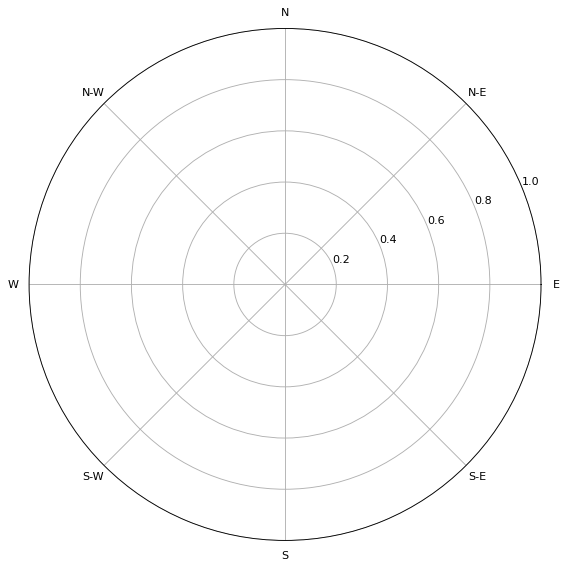

In [13]:
from windrose import WindroseAxes

#fig, ax = plt.subplots(figsize=(16, 5))

ax = WindroseAxes.from_ax()
ax.bar(df1.Dir, df1.Velocidad, normed=True, bins=8, opening=0.8, edgecolor='white', cmap=plt.get_cmap('jet'))
ax.legend(fontsize=14)
ax.tick_params(labelsize=20)

plt.tight_layout()